In [357]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st

import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_rows', 300)
sns.set_palette("colorblind")
palette = sns.color_palette()

In [358]:
DATASET_FPATH = 'owid-covid-data.csv'

### *1.*

In [359]:
# Подготовка данных

df = pd.read_csv(DATASET_FPATH, parse_dates=['date']) # загружаем датасет
df = df[(df.location == 'Russia') & (df.date >= '2020-03-03')] # оставляем данные только по России начиная от 3 марта 2020
df.reset_index(inplace=True, drop=True)
df_sorted = df.sort_values(by='date')

df_sorted.loc[df['new_cases'] == 0, 'new_cases'] = 1

df_train = df_sorted[:50]

target_columns_name = ['new_cases', 'total_cases']
Y_train = df_train[target_columns_name]

In [360]:
df_train.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,RUS,Europe,Russia,2020-03-03,3.0,1.0,0.143,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
1,RUS,Europe,Russia,2020-03-04,3.0,1.0,0.143,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
2,RUS,Europe,Russia,2020-03-05,4.0,1.0,0.286,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
3,RUS,Europe,Russia,2020-03-06,13.0,9.0,1.571,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
4,RUS,Europe,Russia,2020-03-07,13.0,1.0,1.571,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN


### *2.*

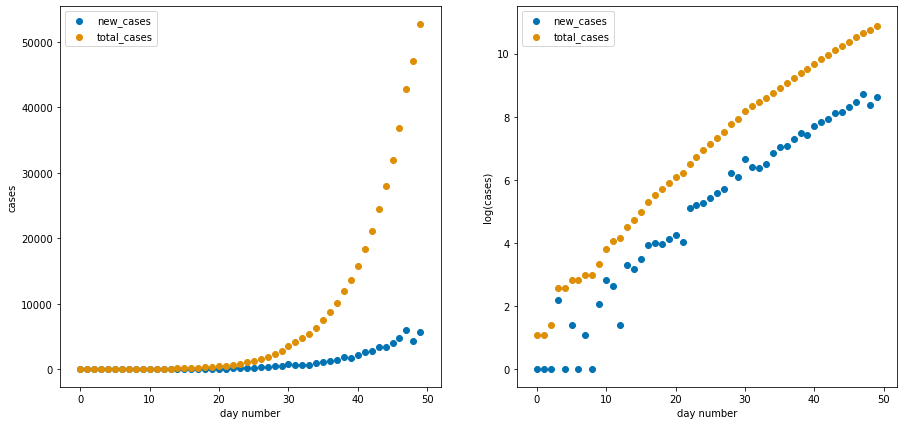

In [361]:
# Графики зависимости целевых переменных от количества дней прошедщих с 3 марта 2020

fix, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(15, 7))

ax_1.scatter(df_train.index, df_train.new_cases, label='new_cases')
ax_1.scatter(df_train.index, df_train.total_cases, label='total_cases')
ax_1.set_ylabel('cases')
ax_1.set_xlabel('day number')
ax_1.legend()

ax_2.scatter(df_train.index, np.log(df_train.new_cases), label='new_cases')
ax_2.scatter(df_train.index, np.log(df_train.total_cases), label='total_cases')
ax_2.set_ylabel('log(cases)')
ax_2.set_xlabel('day number')
ax_2.legend()

plt.show()

### *2a.*

In [362]:
# выбираем априорное распределение весов - нормальное, с нулевым вектором средних mu_0
# и с одинаковой дисперсией, которую задаем косвенно через alpha

alpha=0.5
mu_0 = np.array([0, 0])

x_train = df_train.index._data.reshape(-1, 1)

lr = Ridge(alpha=alpha)

lr.fit(x_train, np.log(Y_train.total_cases))

Ridge(alpha=0.5)

### *2b.*

In [363]:
# Дисперсия шума данных и весов

data_variance = np.sum((lr.predict(x_train) - np.log(Y_train.total_cases)) ** 2) / (x_train.shape[0] - 1) # Дисперсия шума данных
weight_variance = data_variance / alpha # Дисперсия весов

print(f'data variance = {data_variance}')
print(f'weights variance = {weight_variance}')

data variance = 0.12431681675807013
weights variance = 0.24863363351614026


In [364]:
# Апостериорное распределение

Ones = np.ones((x_train.shape[0], 1))
X_train_extended = np.hstack((x_train, Ones))

sigma_0_inverted = np.matrix(np.eye(X_train_extended.T.shape[0]) * weight_variance).I

sigma_n = np.matrix(sigma_0_inverted + X_train_extended.T @ X_train_extended / data_variance).I

mu_n = np.array(sigma_n @ (sigma_0_inverted @ mu_0 + X_train_extended.T @ np.log(Y_train.total_cases) / data_variance).T).flatten()

post_dist = st.multivariate_normal(mu_n, sigma_n)

### *2c.*

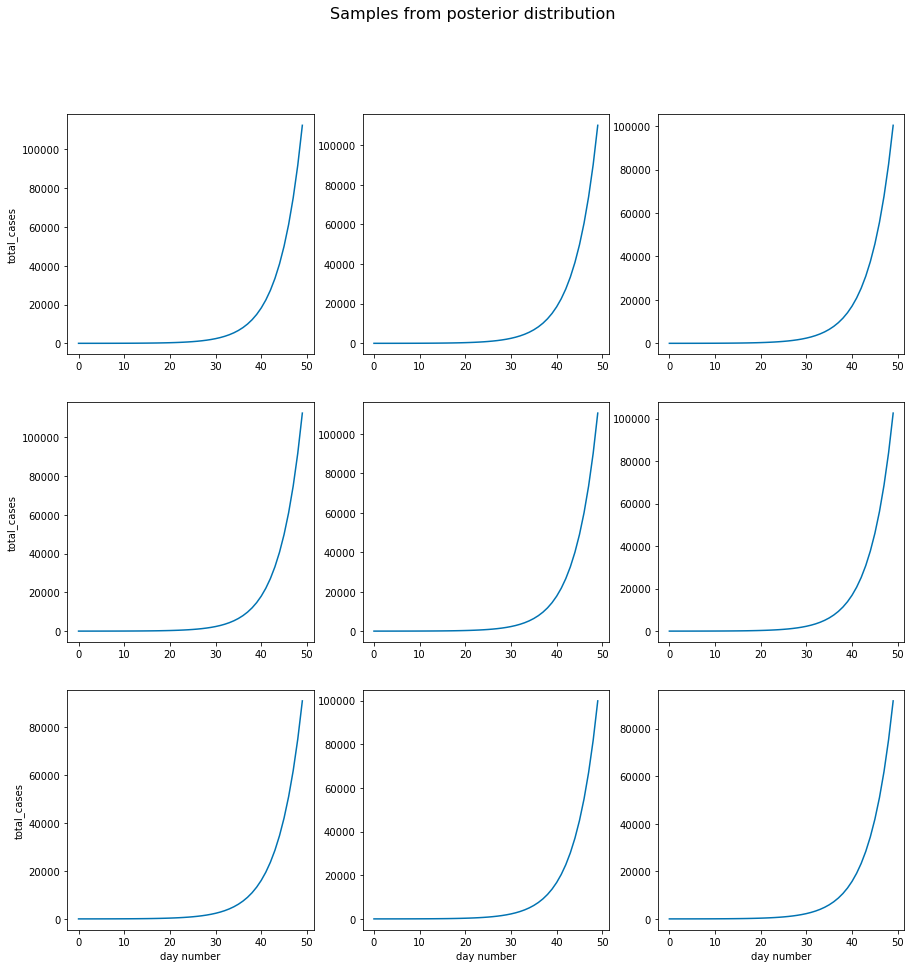

In [365]:
# Графики сэмплов

n_days = 50

Ones = np.ones((df_sorted.index._data.reshape(-1, 1).shape[0], 1))
X_extended = np.hstack((df_sorted.index._data.reshape(-1, 1), Ones))

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for ax in axes.flatten():
    weights = post_dist.rvs()
    ax.plot([x for x in range(X_extended[:n_days].shape[0])], np.exp([weights.T @ x for x in X_extended[:n_days]]))

for i in range(3):    
    axes[i][0].set_ylabel('total_cases')
    axes[2][i].set_xlabel('day number')
    
fig.suptitle('Samples from posterior distribution', fontsize=16)
    
plt.show()

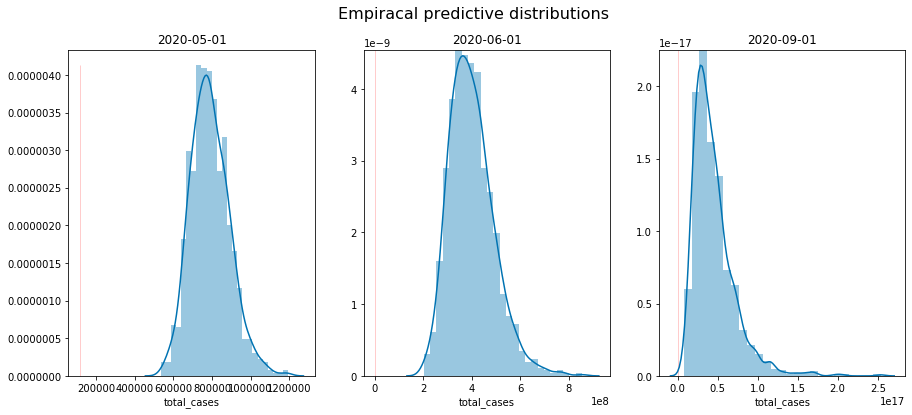

In [366]:
# Предсказательные распределения для 2020-05-01, 2020-06-01 и 2020-09-01

may_1_2020 = []
jun_1_2020 = []
sep_1_2020 = []

for i in range(1000):
    weights = post_dist.rvs()
    may_1_2020.append(np.exp(weights.T @  [df[df.date == '2020-05-01'].index[0], 1.]))
    jun_1_2020.append(np.exp(weights.T @  [df[df.date == '2020-06-01'].index[0], 1.]))
    sep_1_2020.append(np.exp(weights.T @  [df[df.date == '2020-09-01'].index[0], 1.]))
    
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
fig.suptitle(f'Empiracal predictive distributions', fontsize=16)

for ax, x, t in zip(axes, (may_1_2020, jun_1_2020, sep_1_2020), ('2020-05-01', '2020-06-01', '2020-09-01')):
    y_lim = sns.distplot(x, bins=25, norm_hist=True, ax=ax).dataLim._points[1, 1]
    sns.lineplot(df[df.date == f'{t}'].total_cases.values[0] * np.ones(2), np.linspace(0, y_lim, 2), color='r', ax=ax)
    ax.set_xlabel('total_cases')
    ax.set_title(f'{t}')
    


In [367]:
# Наблюдения для формирования эмпирического предсказательного распределения

res = []

for i in range(1000):
    weights = post_dist.rvs()
    res.append(np.exp([weights.T @ x for x in X_extended]))
        
res = np.array(res)
means = np.mean(res, axis=0)
stds = np.std(res, axis=0)

In [368]:
means.shape

(732,)

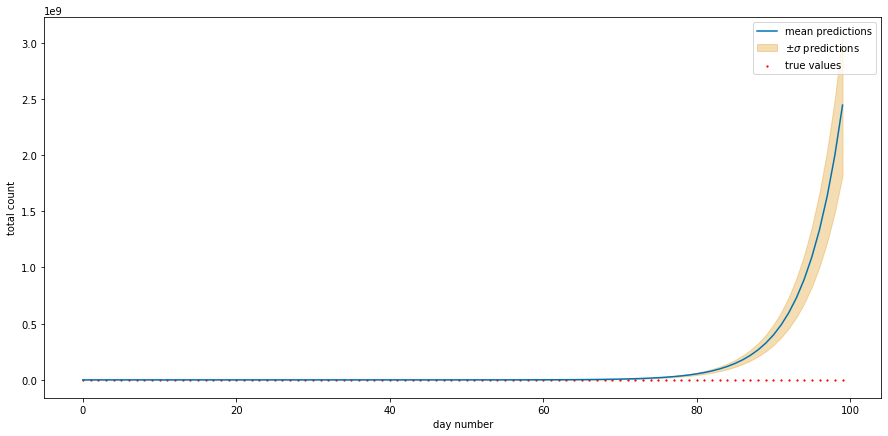

In [369]:
# Графики предсказательного распределения

n_days = 100

fig = plt.figure(figsize=(15, 7))

plt.plot(df_sorted[:n_days].index, means[:n_days], label='mean predictions')
plt.fill_between(
    df_sorted[:n_days].index, means[:n_days] - stds[:n_days], 
    means[:n_days] + stds[:n_days], 
    color=palette[1], 
    alpha =.3, 
    label='$\pm \sigma$ predictions'
)
plt.scatter(df_sorted[:n_days].index, df_sorted[:n_days].total_cases, color='r', s=1.5, label='true values')
plt.xlabel('day number')
plt.ylabel('total count')
plt.legend()
plt.show()

### *3a.*

Берем за основу сигмоиду:

$$  y \propto \Phi_{\mu, \sigma} (x), $$

или

$$  y = C \cdot \int_{-\infty}^x e^{-\frac{(t-\mu)^2}{2\sigma^2}} dt,$$

тогда

$$  y^{'} = e^{-\frac{(x-\mu)^2}{2\sigma^2} + C}, $$

итого

$$  \ln{y^{'}} = \frac{1}{2\sigma^2}x^{2} + \frac{\mu}{\sigma^2}x - \frac{\mu^{2}}{2\sigma^2} + C. $$

Таким образом, обучаем регрессию на данных:  $$ \mathbf{X} = (\mathbf{x^2}, \mathbf{x}, \mathbf{1}),\space \ln{\mathbf{y^{'}}}.$$

Координаты векотора $\mathbf{y^{'}}$ - соответствуют значениям столбца *new_cases*.

### *3b.*

In [370]:
# Линейная модель с l2 регуляризацией (нормальное распределение весов)

alpha=0.5
mu_0 = np.array([0, 0, 0])

X_train = np.hstack((df_train.index._data.reshape(-1, 1) ** 2, df_train.index._data.reshape(-1, 1)))

lr = Ridge(alpha=alpha)
lr.fit(X_train, np.log(Y_train.new_cases))

Ridge(alpha=0.5)

In [371]:
# Дисперсия данных и весов

data_variance = np.sum((lr.predict(X_train) - np.log(Y_train.new_cases)) ** 2) / (X_train.shape[0] - 1)

weight_variance = data_variance / alpha

print(f'data variance = {data_variance}')
print(f'weights variance = {weight_variance}')

data variance = 0.24417081981623906
weights variance = 0.4883416396324781


In [372]:
# Апостериорное распределение

Ones = np.ones((X_train.shape[0], 1))
X_train_extended = np.hstack((X_train, Ones))

sigma_0_inverted = np.matrix(np.eye(X_train_extended.T.shape[0]) * weight_variance).I

sigma_n = np.matrix(sigma_0_inverted + X_train_extended.T @ X_train_extended / data_variance).I

mu_n = np.array(sigma_n @ (sigma_0_inverted @ mu_0 + X_train_extended.T @ np.log(Y_train.new_cases) / data_variance).T).flatten()

post_dist = st.multivariate_normal(mu_n, sigma_n)

In [373]:
mu_n_dict = {'Russia': mu_n.copy()}

### *3c.*

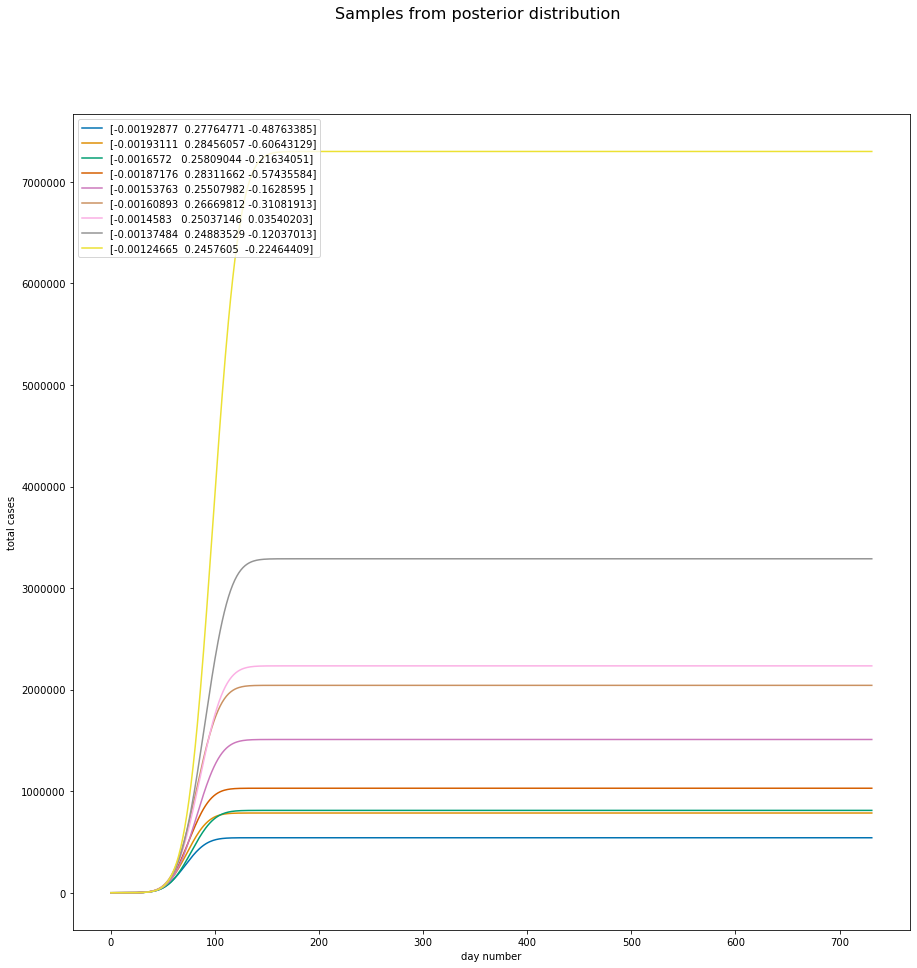

In [276]:
# Cэмплы сигмоид
n_samples = 9

X = np.hstack((df_sorted.index._data.reshape(-1, 1) ** 2, df_sorted.index._data.reshape(-1, 1)))
Ones = np.ones((df_sorted.index._data.reshape(-1, 1).shape[0], 1))
X_extended = np.hstack((X, Ones))

fig = plt.figure(figsize=(15, 15))

sim_result_list = []
for i in range(n_samples):
    weights = post_dist.rvs()
    sim_result_list.append([weights, np.cumsum(np.exp([weights.T @ x for x in  X_extended]))])


sim_result_sorted_list = sorted(sim_result_list, key=lambda x: x[1][200])

for x_ in sim_result_sorted_list:
    sns.lineplot(
        [x for x in range(X_extended.shape[0])], 
        x_[1],
        label=x_[0]
    )

fig.suptitle('Samples from posterior distribution', fontsize=16)
plt.xlabel('day number')
plt.ylabel('total cases')
plt.legend()    
plt.show()

In [277]:
# Наблюдения для формирования эмпирического предсказательного распределения

res = []

for i in range(1000):
    weights = post_dist.rvs()
    res.append(np.cumsum(np.exp([weights.T @ x for x in  X_extended])))
        
res = np.array(res)

medians = np.median(res, axis=0)
means = np.mean(res, axis=0)
q_10 = np.quantile(res, 0.1, axis=0)
q_90 = np.quantile(res, 0.9, axis=0)

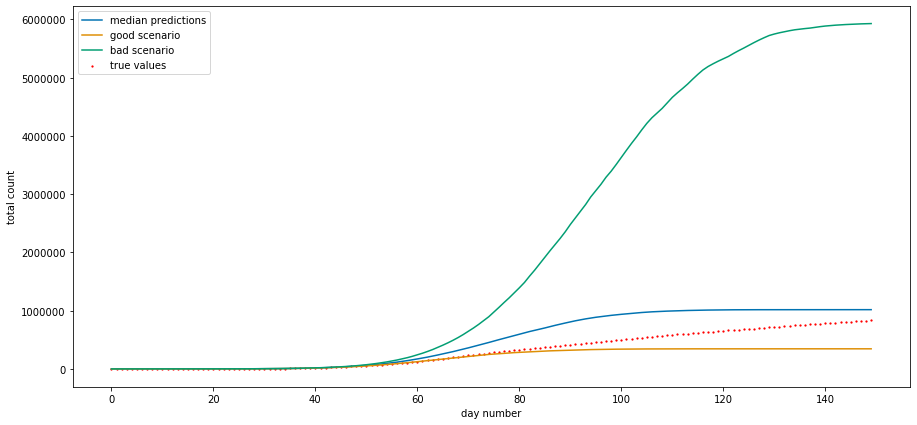

good scenario total cases: 344677
bad scenario total cases: 5940853


In [278]:
# Строим графики предсказательного распределения

n_days = 150

fig = plt.figure(figsize=(15, 7))

plt.plot(df_sorted[:n_days].index, medians[:n_days], label='median predictions')
# plt.plot(df_sorted[:n_days].index, means[:n_days], label='mean predictions')
plt.plot(df_sorted[:n_days].index, q_10[:n_days], label='good scenario')
plt.plot(df_sorted[:n_days].index, q_90[:n_days], label='bad scenario')

plt.scatter(df_sorted[:n_days].index, df_sorted[:n_days].total_cases, color='r', s=1.5, label='true values')
plt.xlabel('day number')
plt.ylabel('total count')
plt.legend()
plt.show()

print(f'good scenario total cases: {int(q_10[200])}')
print(f'bad scenario total cases: {int(q_90[200])}')

### *4*

Italy

In [375]:
# Подготовка данных
df_ = pd.read_csv(DATASET_FPATH, parse_dates=['date']) # загружаем датасет

In [376]:
df_italy = df_[df_['location'] == 'Italy']

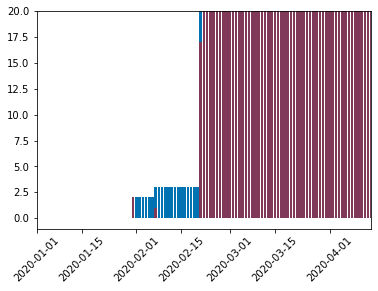

In [377]:
plt.bar(x=df_italy['date'], height=df_italy['total_cases'])
plt.bar(x=df_italy['date'], height=df_italy['new_cases'], alpha=0.5, color='r')
plt.xlim(left=df_['date'].min(), right=df_['date'][50])
plt.ylim(-1, 20)
plt.xticks(rotation=45)
plt.show()

In [378]:
df_italy.loc[df_italy['total_cases'] > 2, 'date'].min()

Timestamp('2020-02-07 00:00:00')

In [379]:
# Подготовка данных
df_italy = df_italy[
    df_italy.date > df_italy.loc[df_italy['total_cases'] > 2, 'date'].min()
]
df_italy.reset_index(inplace=True, drop=True)
df_sorted = df_italy.sort_values(by='date')

df_sorted.loc[df_sorted['new_cases'] == 0, 'new_cases'] = 1

df_train = df_sorted[:50]

target_columns_name = ['new_cases', 'total_cases']
Y_train = df_train[target_columns_name]

In [380]:
df_train.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,ITA,Europe,Italy,2020-02-08,3.0,1.0,0.143,NaN,NaN,NaN,...,19.8,27.8,NaN,3.18,83.51,0.892,NaN,NaN,NaN,NaN
1,ITA,Europe,Italy,2020-02-09,3.0,1.0,0.143,NaN,NaN,NaN,...,19.8,27.8,NaN,3.18,83.51,0.892,-7684.4,-8.48,-5.62,-127.293721
2,ITA,Europe,Italy,2020-02-10,3.0,1.0,0.143,NaN,NaN,NaN,...,19.8,27.8,NaN,3.18,83.51,0.892,NaN,NaN,NaN,NaN
3,ITA,Europe,Italy,2020-02-11,3.0,1.0,0.143,NaN,NaN,NaN,...,19.8,27.8,NaN,3.18,83.51,0.892,NaN,NaN,NaN,NaN
4,ITA,Europe,Italy,2020-02-12,3.0,1.0,0.143,NaN,NaN,NaN,...,19.8,27.8,NaN,3.18,83.51,0.892,NaN,NaN,NaN,NaN


data variance = 0.6767450044344187
weights variance = 1.3534900088688373


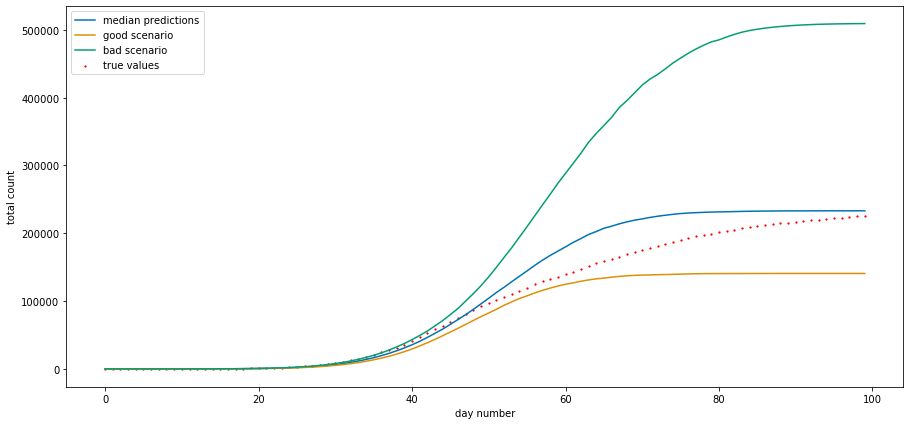

good scenario total cases: 140750
bad scenario total cases: 509567


In [382]:
# Линейная модель с l2 регуляризацией (нормальное распределение весов)

alpha=0.5
mu_0 = np.array([0, 0, 0])

X_train = np.hstack((df_train.index._data.reshape(-1, 1) ** 2, df_train.index._data.reshape(-1, 1)))

lr = Ridge(alpha=alpha)
lr.fit(X_train, np.log(Y_train.new_cases))

# Дисперсия данных и весов

data_variance = np.sum((lr.predict(X_train) - np.log(Y_train.new_cases)) ** 2) / (X_train.shape[0] - 1)

weight_variance = data_variance / alpha

print(f'data variance = {data_variance}')
print(f'weights variance = {weight_variance}')

# Апостериорное распределение

Ones = np.ones((X_train.shape[0], 1))
X_train_extended = np.hstack((X_train, Ones))

sigma_0_inverted = np.matrix(np.eye(X_train_extended.T.shape[0]) * weight_variance).I

sigma_n = np.matrix(sigma_0_inverted + X_train_extended.T @ X_train_extended / data_variance).I

mu_n = np.array(sigma_n @ (sigma_0_inverted @ mu_0 + X_train_extended.T @ np.log(Y_train.new_cases) / data_variance).T).flatten()

post_dist = st.multivariate_normal(mu_n, sigma_n)

X = np.hstack((df_sorted.index._data.reshape(-1, 1) ** 2, df_sorted.index._data.reshape(-1, 1)))
Ones = np.ones((df_sorted.index._data.reshape(-1, 1).shape[0], 1))
X_extended = np.hstack((X, Ones))

# Наблюдения для формирования эмпирического предсказательного распределения

res = []

for i in range(1000):
    weights = post_dist.rvs()
    res.append(np.cumsum(np.exp([weights.T @ x for x in  X_extended])))
        
res = np.array(res)

medians = np.median(res, axis=0)
means = np.mean(res, axis=0)
q_10 = np.quantile(res, 0.1, axis=0)
q_90 = np.quantile(res, 0.9, axis=0)


# Строим графики предсказательного распределения

n_days = 100

fig = plt.figure(figsize=(15, 7))

plt.plot(df_sorted[:n_days].index, medians[:n_days], label='median predictions')
plt.plot(df_sorted[:n_days].index, q_10[:n_days], label='good scenario')
plt.plot(df_sorted[:n_days].index, q_90[:n_days], label='bad scenario')

plt.scatter(df_sorted[:n_days].index, df_sorted[:n_days].total_cases, color='r', s=1.5, label='true values')
plt.xlabel('day number')
plt.ylabel('total count')
plt.legend()
plt.show()

print(f'good scenario total cases: {int(q_10[200])}')
print(f'bad scenario total cases: {int(q_90[200])}')

In [383]:
mu_n_dict['Italy'] = mu_n.copy()

Spain

In [384]:
# Подготовка данных
df_ = pd.read_csv(DATASET_FPATH, parse_dates=['date']) # загружаем датасет
# location_list = ['China', 'Italy', 'Sweden']

In [385]:
df_spain = df_[df_['location'] == 'Spain'][['date', 'total_cases', 'new_cases']]

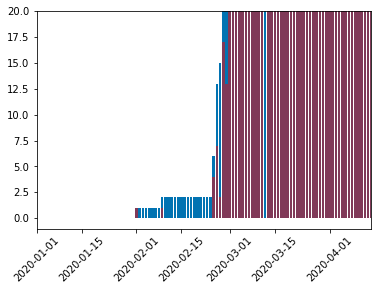

In [386]:
plt.bar(x=df_spain['date'], height=df_spain['total_cases'])
plt.bar(x=df_spain['date'], height=df_spain['new_cases'], alpha=0.5, color='r')
plt.xlim(left=df_['date'].min(), right=df_['date'][50])
plt.ylim(-1, 20)
plt.xticks(rotation=45)
plt.show()

In [387]:
df_spain.loc[df_spain['new_cases'] > 2, 'date'].min()

Timestamp('2020-02-25 00:00:00')

In [388]:
# Подготовка данных
df_spain = df_spain[
    df_spain.date >= df_spain.loc[df_spain['new_cases'] > 2, 'date'].min()
]
df_spain.reset_index(inplace=True, drop=True)
df_sorted = df_spain.sort_values(by='date')

df_sorted.loc[df_spain['new_cases'] == 0, 'new_cases'] = 1

df_train = df_sorted[:50]
df_train.head()

target_columns_name = ['new_cases', 'total_cases']
Y_train = df_train[target_columns_name]

data variance = 0.986814006319972
weights variance = 1.973628012639944
mu_0:
[0 0 0] 

mu_n:
[-0.00595115  0.43717739  0.88060855] 

sigma_0:
[[1.97362801 0.         0.        ]
 [0.         1.97362801 0.        ]
 [0.         0.         1.97362801]] 

sigma_n:
[[ 5.45870666e-07 -2.65040908e-05  2.05954249e-04]
 [-2.65040908e-05  1.37901229e-03 -1.22348947e-02]
 [ 2.05954249e-04 -1.22348947e-02  1.51462565e-01]] 



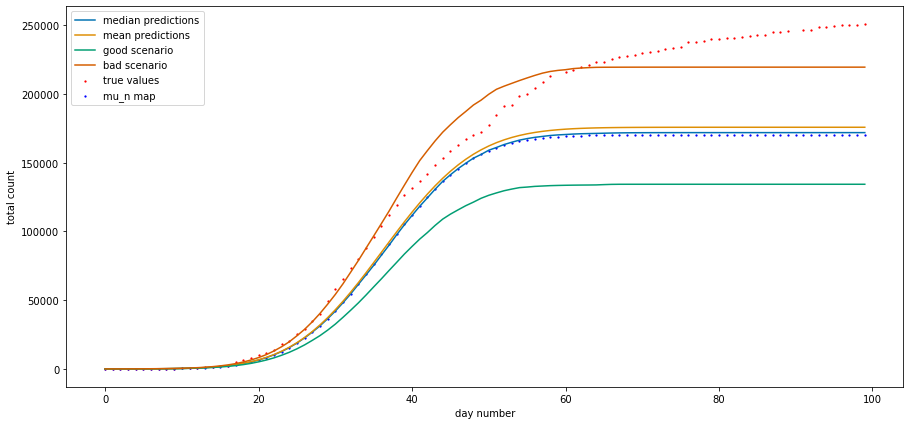

good scenario total cases: 134268
bad scenario total cases: 219432


In [389]:
# Линейная модель с l2 регуляризацией (нормальное распределение весов)
alpha=0.5
mu_0 = np.array([0, 0, 0])

X_train = np.hstack((df_train.index._data.reshape(-1, 1) ** 2, df_train.index._data.reshape(-1, 1)))

lr = Ridge(alpha=alpha)
lr.fit(X_train, np.log(Y_train.new_cases))

# Дисперсия данных и весов

data_variance = np.sum((lr.predict(X_train) - np.log(Y_train.new_cases)) ** 2) / (X_train.shape[0] - 1)

weight_variance = data_variance / alpha

print(f'data variance = {data_variance}')
print(f'weights variance = {weight_variance}')

# Апостериорное распределение

Ones = np.ones((X_train.shape[0], 1))
X_train_extended = np.hstack((X_train, Ones))

sigma_0 = np.matrix(np.eye(X_train_extended.T.shape[0]) * weight_variance)
sigma_0_inverted = sigma_0.I

sigma_n = np.matrix(sigma_0_inverted + X_train_extended.T @ X_train_extended / data_variance).I

mu_n = np.array(sigma_n @ (sigma_0_inverted @ mu_0 + X_train_extended.T @ np.log(Y_train.new_cases) / data_variance).T).flatten()

print('mu_0:')
print(mu_0, '\n')
print('mu_n:')
print(mu_n, '\n')
print('sigma_0:')
print(sigma_0, '\n')
print('sigma_n:')
print(sigma_n, '\n')

post_dist = st.multivariate_normal(mu_n, sigma_n)

X = np.hstack((df_sorted.index._data.reshape(-1, 1) ** 2, df_sorted.index._data.reshape(-1, 1)))
Ones = np.ones((df_sorted.index._data.reshape(-1, 1).shape[0], 1))
X_extended = np.hstack((X, Ones))

# Наблюдения для формирования эмпирического предсказательного распределения

res = []

for i in range(1000):
    weights = post_dist.rvs()
    res.append(np.cumsum(np.exp([weights.T @ x for x in  X_extended])))
        
res = np.array(res)

medians = np.median(res, axis=0)
means = np.mean(res, axis=0)
q_10 = np.quantile(res, 0.1, axis=0)
q_90 = np.quantile(res, 0.9, axis=0)

# Строим графики предсказательного распределения

n_days = 100

fig = plt.figure(figsize=(15, 7))

plt.plot(df_sorted[:n_days].index, medians[:n_days], label='median predictions')
plt.plot(df_sorted[:n_days].index, means[:n_days], label='mean predictions')
plt.plot(df_sorted[:n_days].index, q_10[:n_days], label='good scenario')
plt.plot(df_sorted[:n_days].index, q_90[:n_days], label='bad scenario')

plt.scatter(df_sorted[:n_days].index, np.cumsum(df_sorted[:n_days].new_cases), color='r', s=1.5, label='true values')
plt.scatter(df_sorted[:n_days].index, np.cumsum(np.exp(mu_n @ X_extended[:n_days].T)), color='b', s=1.5, label='mu_n map')
plt.xlabel('day number')
plt.ylabel('total count')
plt.legend()
plt.show()

print(f'good scenario total cases: {int(q_10[200])}')
print(f'bad scenario total cases: {int(q_90[200])}')

In [390]:
mu_n_dict['Spain'] = mu_n.copy()

Austia

In [399]:
# Подготовка данных
df_ = pd.read_csv(DATASET_FPATH, parse_dates=['date']) # загружаем датасет

In [400]:
df_aust = df_[df_['location'] == 'Austria']

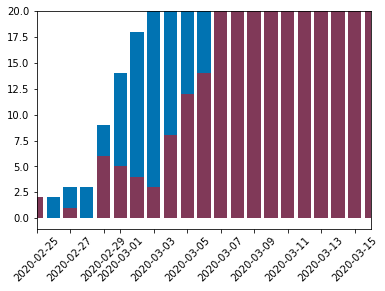

In [407]:
plt.bar(x=df_aust['date'], height=df_aust['total_cases'])
plt.bar(x=df_aust['date'], height=df_aust['new_cases'], alpha=0.5, color='r')
plt.xlim(left=df_aust['date'].min(), right=df_aust['date'].iloc[20])
plt.ylim(-1, 20)
plt.xticks(rotation=45)
plt.show()

In [409]:
df_aust.loc[df_aust['total_cases'] > 2, 'date'].min()

Timestamp('2020-02-27 00:00:00')

In [410]:
# Подготовка данных
df_aust = df_aust[
    df_aust.date > df_aust.loc[df_aust['total_cases'] > 2, 'date'].min()
]
df_aust.reset_index(inplace=True, drop=True)
df_sorted = df_aust.sort_values(by='date')

df_sorted.loc[df_sorted['new_cases'] == 0, 'new_cases'] = 1

df_train = df_sorted[:50]

target_columns_name = ['new_cases', 'total_cases']
Y_train = df_train[target_columns_name]

In [411]:
df_train.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AUT,Europe,Austria,2020-02-28,3.0,1.0,NaN,NaN,NaN,NaN,...,28.4,30.9,NaN,7.37,81.54,0.922,NaN,NaN,NaN,NaN
1,AUT,Europe,Austria,2020-02-29,9.0,6.0,NaN,NaN,NaN,NaN,...,28.4,30.9,NaN,7.37,81.54,0.922,NaN,NaN,NaN,NaN
2,AUT,Europe,Austria,2020-03-01,14.0,5.0,NaN,NaN,NaN,NaN,...,28.4,30.9,NaN,7.37,81.54,0.922,-749.0,-4.55,-3.64,-82.825836
3,AUT,Europe,Austria,2020-03-02,18.0,4.0,2.571,NaN,NaN,NaN,...,28.4,30.9,NaN,7.37,81.54,0.922,NaN,NaN,NaN,NaN
4,AUT,Europe,Austria,2020-03-03,21.0,3.0,2.714,NaN,NaN,NaN,...,28.4,30.9,NaN,7.37,81.54,0.922,NaN,NaN,NaN,NaN


data variance = 0.15824181858668251
weights variance = 0.31648363717336503


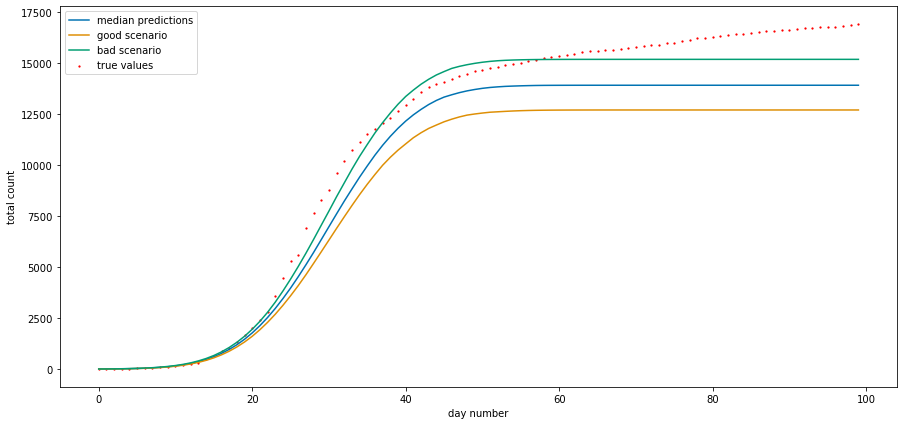

good scenario total cases: 12691
bad scenario total cases: 15171


In [420]:
# Линейная модель с l2 регуляризацией (нормальное распределение весов)

alpha=0.5
mu_0 = np.array([0, 0, 0])

X_train = np.hstack((df_train.index._data.reshape(-1, 1) ** 2, df_train.index._data.reshape(-1, 1)))

lr = Ridge(alpha=alpha)
lr.fit(X_train, np.log(Y_train.new_cases))

# Дисперсия данных и весов

data_variance = np.sum((lr.predict(X_train) - np.log(Y_train.new_cases)) ** 2) / (X_train.shape[0] - 1)

weight_variance = data_variance / alpha

print(f'data variance = {data_variance}')
print(f'weights variance = {weight_variance}')

# Апостериорное распределение

Ones = np.ones((X_train.shape[0], 1))
X_train_extended = np.hstack((X_train, Ones))

sigma_0_inverted = np.matrix(np.eye(X_train_extended.T.shape[0]) * weight_variance).I

sigma_n = np.matrix(sigma_0_inverted + X_train_extended.T @ X_train_extended / data_variance).I

mu_n = np.array(sigma_n @ (sigma_0_inverted @ mu_0 + X_train_extended.T @ np.log(Y_train.new_cases) / data_variance).T).flatten()

post_dist = st.multivariate_normal(mu_n, sigma_n)

X = np.hstack((df_sorted.index._data.reshape(-1, 1) ** 2, df_sorted.index._data.reshape(-1, 1)))
Ones = np.ones((df_sorted.index._data.reshape(-1, 1).shape[0], 1))
X_extended = np.hstack((X, Ones))

# Наблюдения для формирования эмпирического предсказательного распределения

res = []

for i in range(1000):
    weights = post_dist.rvs()
    res.append(np.cumsum(np.exp([weights.T @ x for x in  X_extended])))
        
res = np.array(res)

medians = np.median(res, axis=0)
means = np.mean(res, axis=0)
q_10 = np.quantile(res, 0.1, axis=0)
q_90 = np.quantile(res, 0.9, axis=0)


# Строим графики предсказательного распределения

n_days = 100

fig = plt.figure(figsize=(15, 7))

plt.plot(df_sorted[:n_days].index, medians[:n_days], label='median predictions')
plt.plot(df_sorted[:n_days].index, q_10[:n_days], label='good scenario')
plt.plot(df_sorted[:n_days].index, q_90[:n_days], label='bad scenario')

plt.scatter(df_sorted[:n_days].index, df_sorted[:n_days].total_cases, color='r', s=1.5, label='true values')
plt.xlabel('day number')
plt.ylabel('total count')
plt.legend()
plt.show()

print(f'good scenario total cases: {int(q_10[200])}')
print(f'bad scenario total cases: {int(q_90[200])}')

In [421]:
lr.coef_, lr.intercept_

(array([-0.00650834,  0.39609147]), 0.4173418763375718)

In [418]:
lr.coef_, lr.intercept_

(array([-0.00650275,  0.39579835]), 0.42000019170546565)

In [419]:
mu_n

array([-0.00658409,  0.40063132,  0.36015829])